## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
def camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    original_imgs = []
    undistorted_imgs = []
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        # TODO: Use cv2.cornerSubPix to get more accurate corners

        # If found, add object points, image points
        if ret == True:
            original_imgs.append(img)
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, original_imgs[0].shape[1::-1], None, None)
    return mtx, dist, original_imgs

def undistort(image, mtx, dist, draw_chessboard_corners=False):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if draw_chessboard_corners:
        gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        undist = cv2.drawChessboardCorners(undist, (9,6), corners, ret)
    return undist

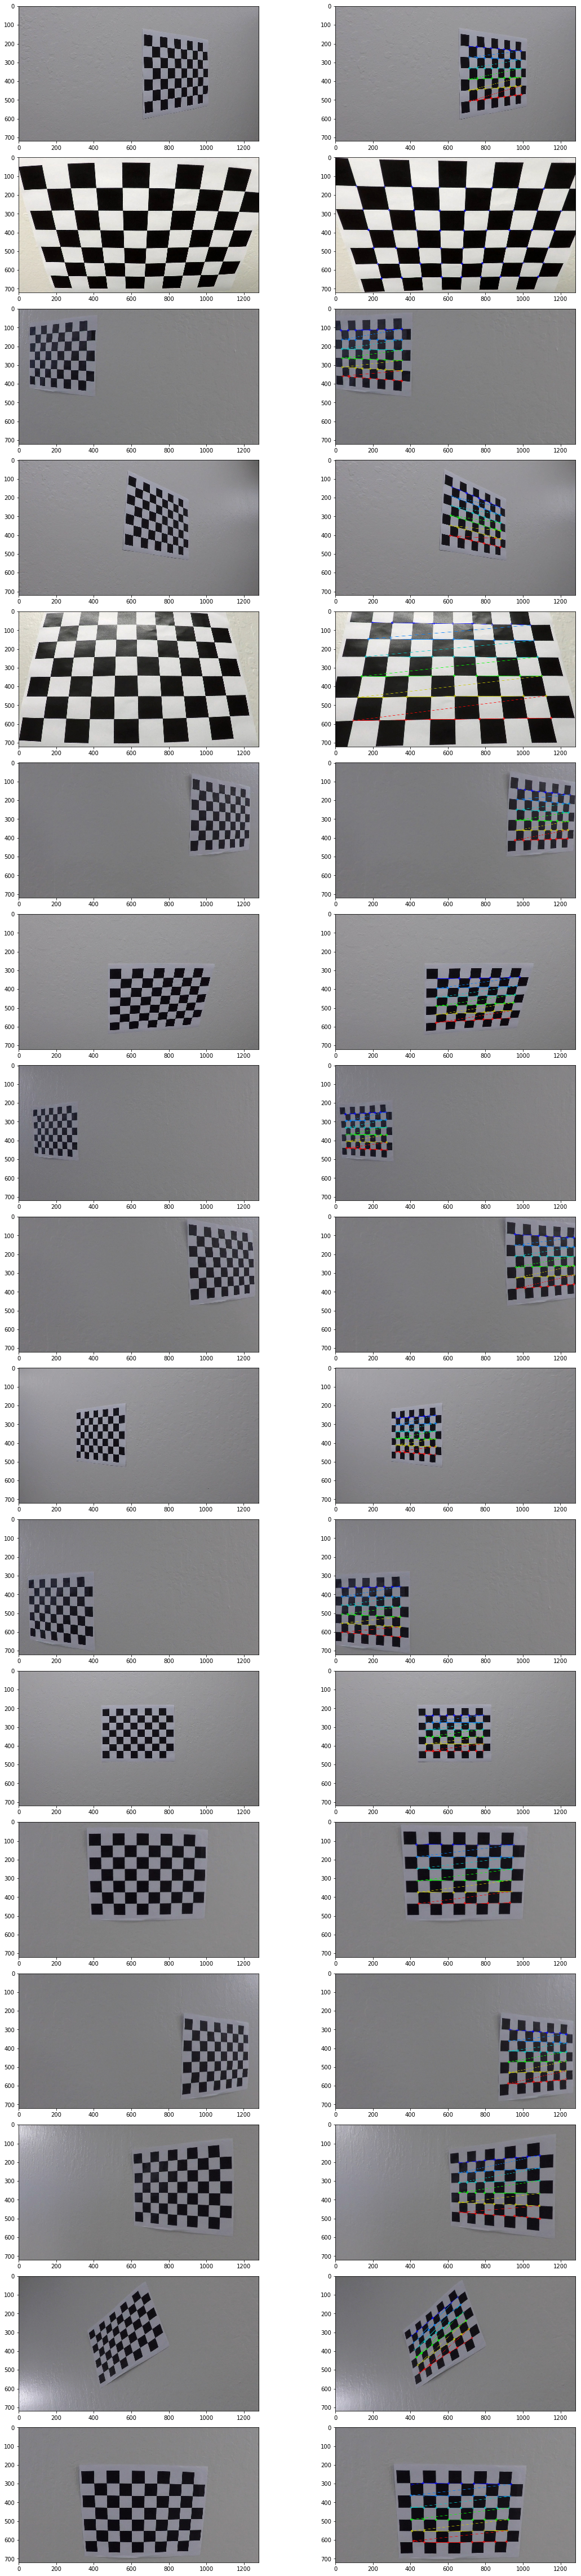

In [11]:
mtx, dist, original_imgs = camera_calibration()

fig, axes = plt.subplots(len(original_imgs), 2, figsize=(15, 70))
fig.tight_layout()
for idx in range(len(original_imgs)):
    undist = undistort(original_imgs[idx], mtx, dist, draw_chessboard_corners=True)
    
    axes[idx, 0].imshow(original_imgs[idx])
#     axes[idx, 0].set_title('Original Image', fontsize=50)
    axes[idx, 1].imshow(undist)
#     axes[idx, 1].set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.close(fig)

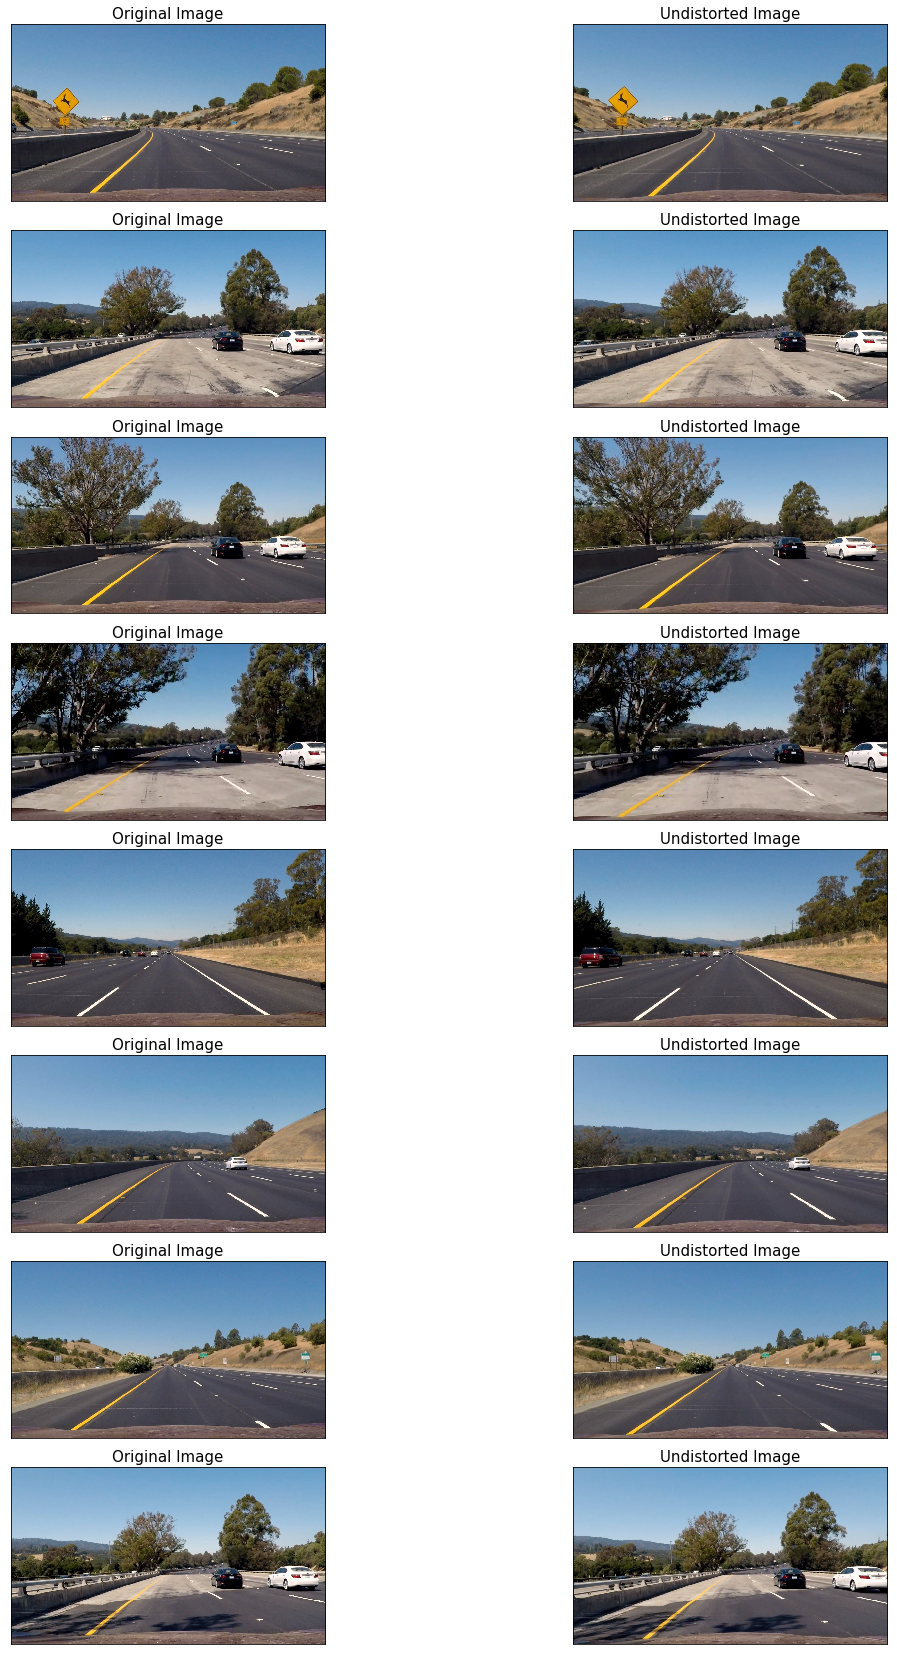

In [20]:
images = glob.glob('../test_images/*.jpg')

# Step through the list and search for chessboard corners
test_imgs = []
undist_test_imgs = []
for fname in glob.glob('../test_images/*.jpg'):
    img = mpimg.imread(fname)
    undist_img = undistort(img, mtx, dist)
    test_imgs.append(img)
    undist_test_imgs.append(undist_img)
    
fig, axes = plt.subplots(len(test_imgs), 2, figsize=(15, 25))
fig.tight_layout()
for idx in range(len(test_imgs)):
    axes[idx, 0].imshow(test_imgs[idx])
    axes[idx, 0].set_title('Original Image', fontsize=15)
    axes[idx, 0].get_xaxis().set_visible(False)
    axes[idx, 0].get_yaxis().set_visible(False)
    axes[idx, 1].imshow(undist_test_imgs[idx])
    axes[idx, 1].set_title('Undistorted Image', fontsize=15)
    axes[idx, 1].get_xaxis().set_visible(False)
    axes[idx, 1].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.close(fig)

## Gradient threshold function

In [ ]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    dx = 1 if orient == 'x' else 0
    dy = 0 if orient == 'x' else 1
    # Apply the following steps to image
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # 6) Return this mask as your grad_binary image
    return grad_binary

In [ ]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * mag / np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled > mag_thresh[0]) & (scaled < mag_thresh[1])] = 1
    # 6) Return this mask as your mag_binary image
    return mag_binary

In [ ]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction > thresh[0]) & (direction < thresh[1])] = 1
    # 6) Return this mask as your dir_binary image
    return dir_binary

In [ ]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Combination
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

## Color space threshold function

In [ ]:
# TODO: Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    saturation = hls[:, :, 2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(saturation)
    binary_output[(saturation > thresh[0]) & (saturation <= thresh[1])] = 1
    return binary_output

## Combine color and gradiant

In [ ]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

In [ ]:
image = mpimg.imread('bridge_shadow.jpg')
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)